Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob as glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# unzip the files
!unzip -q "/content/drive/MyDrive/CNN_data.zip"

The dataset has about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Loading using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Vizualizing one instance of all the nine classes present in the dataset

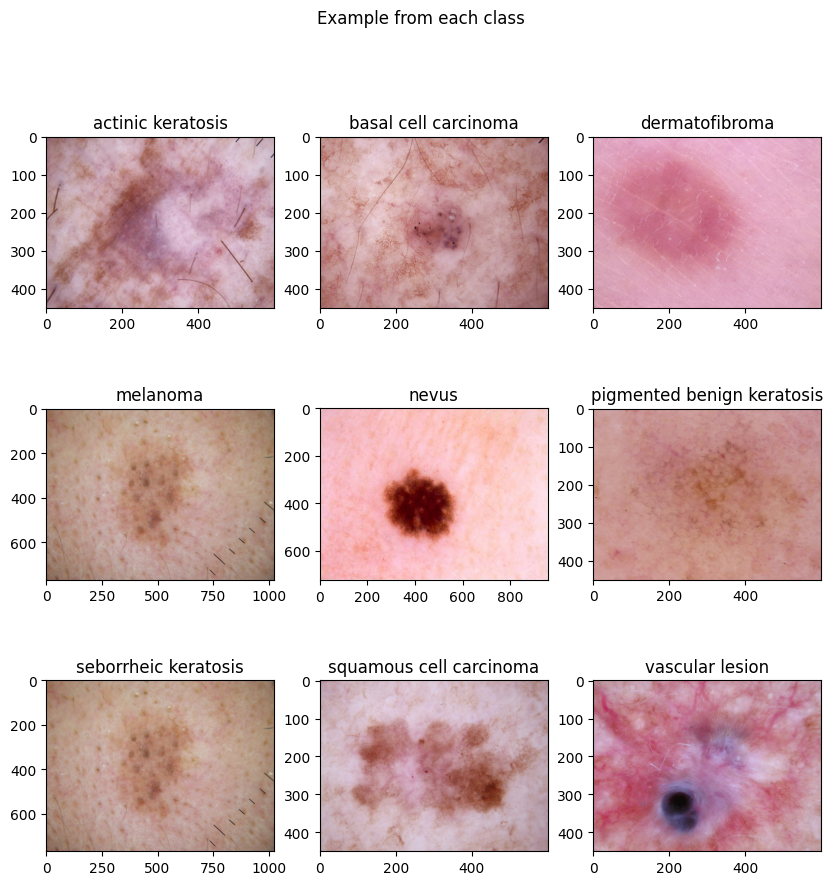

In [ ]:
class_names = train_ds.class_names
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, class_name in enumerate(class_names):
  # Use a list to collect all matching image paths
  image_paths = list(data_dir_train.glob(f"{class_name}/*.jpg"))
  if image_paths:  # Check if any images were found
    image_path = image_paths[0]  # Select the first image
    image = plt.imread(image_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(class_name)
  else:
    print(f"No images found for class: {class_name}")
fig.suptitle("Example from each class")
plt.show()
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### CNN model which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). Since, the RGB channel values are in the `[0, 255]` range, whcih is not ideal for a neural network and hence we standardize values to be in the `[0, 1]`

In [ ]:
model = Sequential()

# Rescale the input image
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(128, activation='relu'))

# Output layer with softmax activation for 9 classes
model.add(layers.Dense(9, activation='softmax'))



### Compiling the model
Using Adam optimiser and Spare Categorical Crossentropy loss function for model training

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 118336)            0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 115s 2s/step - loss: 2.6451 - accuracy: 0.2483 - val_loss: 1.8296 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 98s 2s/step - loss: 1.6621 - accuracy: 0.4135 - val_loss: 1.5041 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 95s 2s/step - loss: 1.4280 - accuracy: 0.4978 - val_loss: 1.4306 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 103s 2s/step - loss: 1.3835 - accuracy: 0.5089 - val_loss: 1.5573 - val_accuracy: 0.4497
Epoch 5/20
56/56 [==============================] - 99s 2s/step - loss: 1.2500 - accuracy: 0.5603 - val_loss: 1.3998 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 99s 2s/step - loss: 1.1327 - accuracy: 0.6060 - val_loss: 1.7166 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 96s 2s/step - loss: 1.0328 - accuracy: 0.6423 - val_loss: 1.5698 - val_accuracy: 0.5257
Epoch 8/20
56/56 [

### Visualizing training results

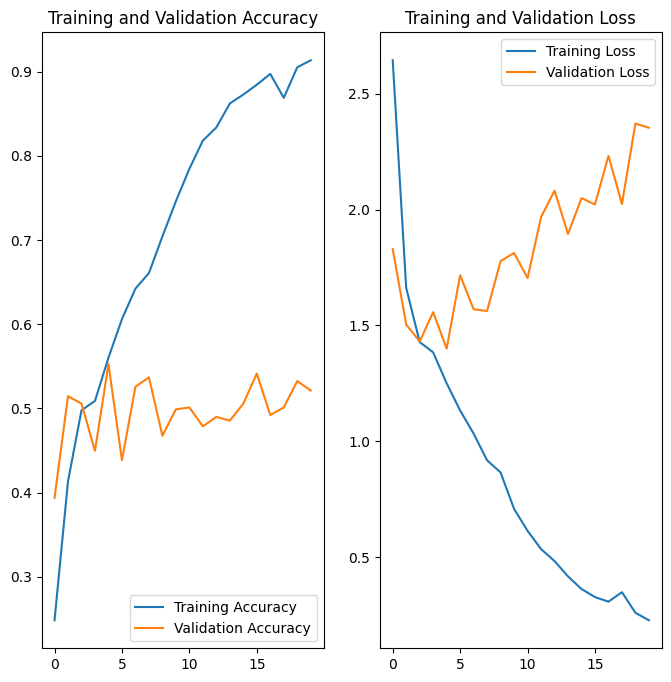

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Finding/Observation
#### We see that there is clear overfitting in our model as training accuracy increase in contrary to the stagnent validation accuracy.
#### This can be due to lack of feature extraction due to less layers.

In [ ]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    #image = tf.image.random_rotation(image, angles=20)
    #image = tf.image.random_zoom(image, zoom_range=(0.8, 1.2))
    return image, label

aug_train_ds = train_ds.map(augment)


class_names = train_ds.class_names


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
train_ds_combined = train_ds.concatenate(aug_train_ds)


<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


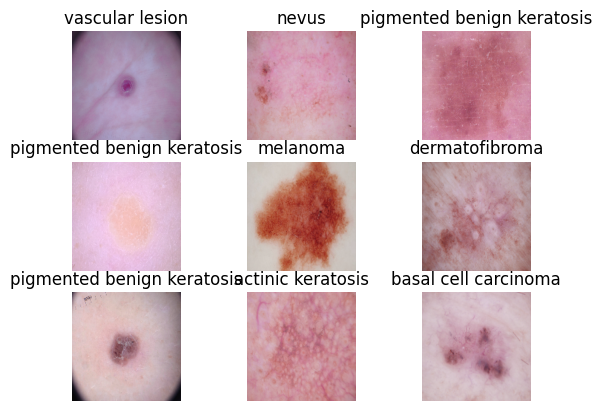

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for images, labels in aug_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

### Creation of the model, compilation and training the model


In [ ]:

model = Sequential()


model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))


model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())


model.add(layers.Dense(128, activation='relu'))


model.add(layers.Dropout(0.5))

model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [ ]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds_combined,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
112/112 [==============================] - 33s 225ms/step - loss: 2.2833 - accuracy: 0.2335 - val_loss: 2.0575 - val_accuracy: 0.2170
Epoch 2/20
112/112 [==============================] - 24s 201ms/step - loss: 2.0081 - accuracy: 0.2486 - val_loss: 2.0260 - val_accuracy: 0.2573
Epoch 3/20
112/112 [==============================] - 25s 208ms/step - loss: 1.9611 - accuracy: 0.2726 - val_loss: 1.8995 - val_accuracy: 0.2953
Epoch 4/20
112/112 [==============================] - 24s 198ms/step - loss: 1.9410 - accuracy: 0.2773 - val_loss: 1.9484 - val_accuracy: 0.3132
Epoch 5/20
112/112 [==============================] - 24s 205ms/step - loss: 1.9076 - accuracy: 0.2829 - val_loss: 1.8709 - val_accuracy: 0.3311
Epoch 6/20
112/112 [==============================] - 23s 189ms/step - loss: 1.8709 - accuracy: 0.3047 - val_loss: 1.9612 - val_accuracy: 0.2931
Epoch 7/20
112/112 [==============================] - 24s 201ms/step - loss: 1.8590 - accuracy: 0.3092 - val_loss: 1.8427 - val_ac

### Visualizing the results

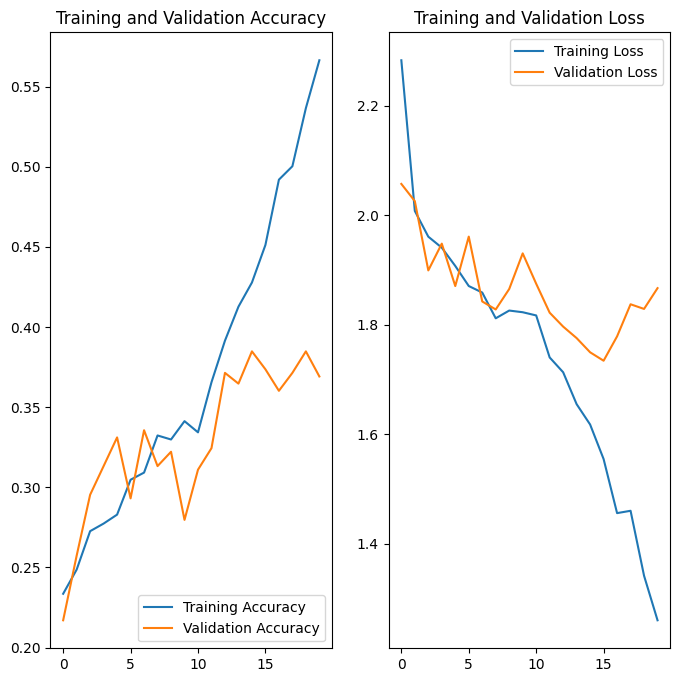

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation
#### We clearly see that our model is underfitting as the training accuracy score is lower than what we observed previously. We can also notice a poor validaton accuracy. This can due to low feature extraction by model, low number of training set, and misbalanced class

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

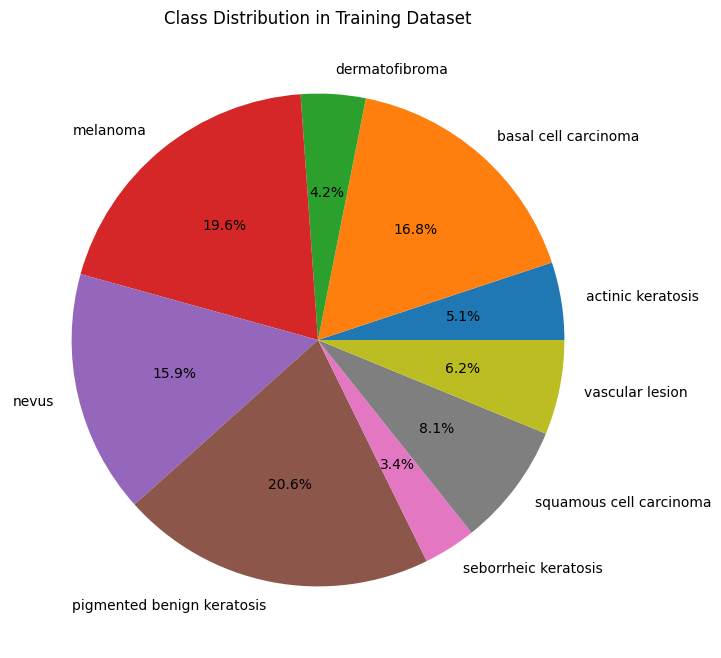

In [ ]:
## Your code goes here.
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
class_names = train_ds.class_names
class_counts = [len(list(data_dir_train.glob(f"{class_name}/*.jpg"))) for class_name in class_names]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct="%1.1f%%")
plt.title("Class Distribution in Training Dataset")
plt.show()


#### **Todo:** Write your findings here:
#### - 'seborrheic keratosis' class has the least number of samples having a proportion of 3.4%
#### - 'pigmented benign keratosis' is the most dominant class having a proportion of 20.6%


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [11]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [12]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBC2C21A500>: 100%|██████████| 500/500 [00:23<00:00, 21.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBC2C237B50>: 100%|██████████| 500/500 [00:24<00:00, 20.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBC3061C2E0>: 100%|██████████| 500/500 [00:25<00:00, 19.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CBC2C236440>: 100%|██████████| 500/500 [01:37<00:00,  5.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3008x2000 at 0x7CBC2C096B30>: 100%|██████████| 500/500 [01:32<00:00,  5.38 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CBC2C0E3850>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CBC2C24BA90>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBC2C234340>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBC305C11E0>: 100%|██████████| 500/500 [00:20<00:00, 23.99 Samples/s]


In [13]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
x = list(data_dir_train.glob('*/*.jpg'))
len(x)

2239

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [15]:
from glob import glob
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg*')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [16]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

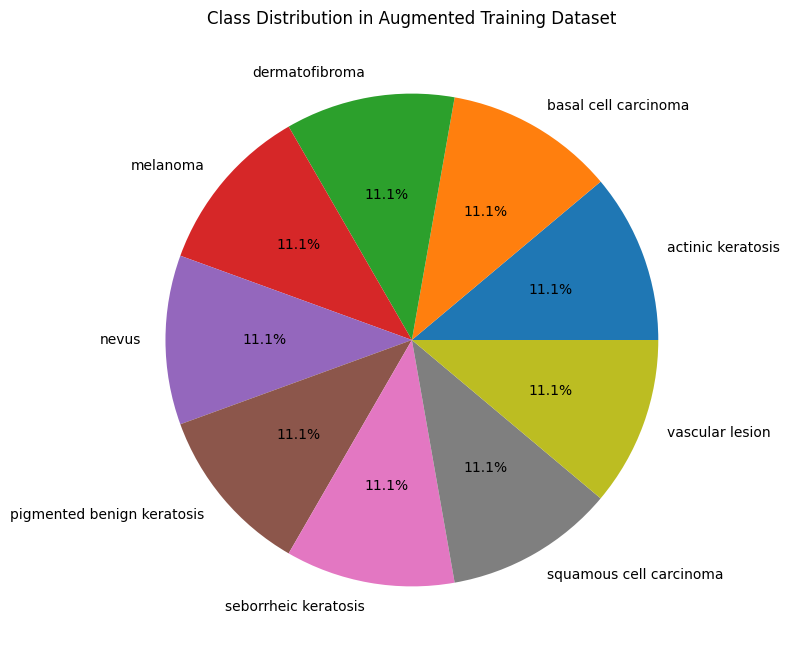

In [17]:
# see the distribution of augmented data after adding new images to the original training data.

class_names = train_ds.class_names
class_counts = [len(list(data_dir_train.glob(f"{class_name}/output/*.jpg"))) for class_name in class_names]
class_values = (list(data_dir_train.glob(f"{class_name}/output/*.jpg")) for class_name in class_names)
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct="%1.1f%%")
plt.title("Class Distribution in Augmented Training Dataset")
plt.show()


In [18]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [19]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [20]:
import shutil
def move_augmented_images(class_name):
    class_folder = data_dir_train / class_name
    output_folder = class_folder / 'output'

    if not output_folder.exists():
        print(f"Output folder does not exist for class: {class_name}")
        return

    for img_file in output_folder.glob('*.jpg'):
        new_path = class_folder / img_file.name
        shutil.move(str(img_file), str(new_path))
        print(f"Moved: {img_file} -> {new_path}")

In [21]:
for class_name in class_names:
    move_augmented_images(class_name)

Moved: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029141.jpg_83ccfb74-1a9a-4d7c-8ce3-6cb4b8a34295.jpg -> /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/actinic keratosis_original_ISIC_0029141.jpg_83ccfb74-1a9a-4d7c-8ce3-6cb4b8a34295.jpg
Moved: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_0ae6a178-7908-4131-a3bd-c415322cf3d8.jpg -> /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/actinic keratosis_original_ISIC_0026212.jpg_0ae6a178-7908-4131-a3bd-c415322cf3d8.jpg
Moved: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_4a8bd33e-97f8-4080-bec4-e46e91bb2bc6.jpg -> /content/Skin cancer ISIC The International Skin 

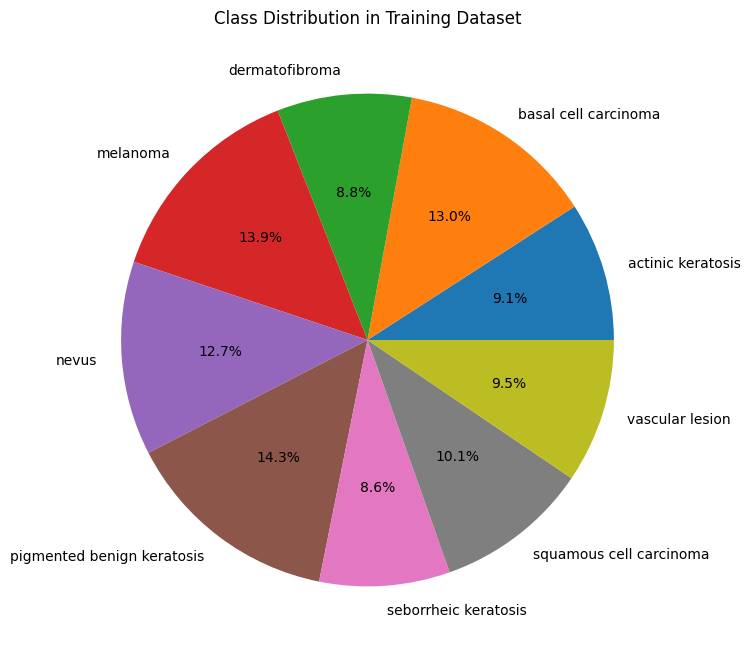

In [22]:

class_counts = [len(list(data_dir_train.glob(f"{class_name}/*.jpg"))) for class_name in class_names]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct="%1.1f%%")
plt.title("Class Distribution in Training Dataset")
plt.show()

In [23]:
for i, class_name in enumerate(class_names):
  print(f"Class: {class_name}, Count: {class_counts[i]}")


Class: actinic keratosis, Count: 614
Class: basal cell carcinoma, Count: 876
Class: dermatofibroma, Count: 595
Class: melanoma, Count: 938
Class: nevus, Count: 857
Class: pigmented benign keratosis, Count: 962
Class: seborrheic keratosis, Count: 577
Class: squamous cell carcinoma, Count: 681
Class: vascular lesion, Count: 639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [24]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [25]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model

In [27]:
## your code goes here
model = Sequential()

# Rescale the input image
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

# Output layer with softmax activation for 9 classes
model.add(layers.Dense(9, activation='softmax'))

####  Compiling the model

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0

#### Model training

In [29]:
epochs = 50
## Your code goes here, use 50 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 469s 3s/step - loss: 1.5903 - accuracy: 0.4308 - val_loss: 2.6778 - val_accuracy: 0.1292
Epoch 2/50
169/169 [==============================] - 456s 3s/step - loss: 1.1727 - accuracy: 0.5877 - val_loss: 2.3494 - val_accuracy: 0.2205
Epoch 3/50
169/169 [==============================] - 449s 3s/step - loss: 0.9059 - accuracy: 0.6944 - val_loss: 1.6399 - val_accuracy: 0.3615
Epoch 4/50
169/169 [==============================] - 456s 3s/step - loss: 0.6309 - accuracy: 0.7906 - val_loss: 2.1150 - val_accuracy: 0.3341
Epoch 5/50
169/169 [==============================] - 446s 3s/step - loss: 0.4499 - accuracy: 0.8570 - val_loss: 3.0770 - val_accuracy: 0.2665
Epoch 6/50
169/169 [==============================] - 449s 3s/step - loss: 0.5132 - accuracy: 0.8349 - val_loss: 2.9009 - val_accuracy: 0.2962
Epoch 7/50
169/169 [==============================] - 448s 3s/step - loss: 0.2994 - accuracy: 0.9086 - val_loss: 1.8244 - val_accuracy: 0.5145

#### Vizualizing the model results

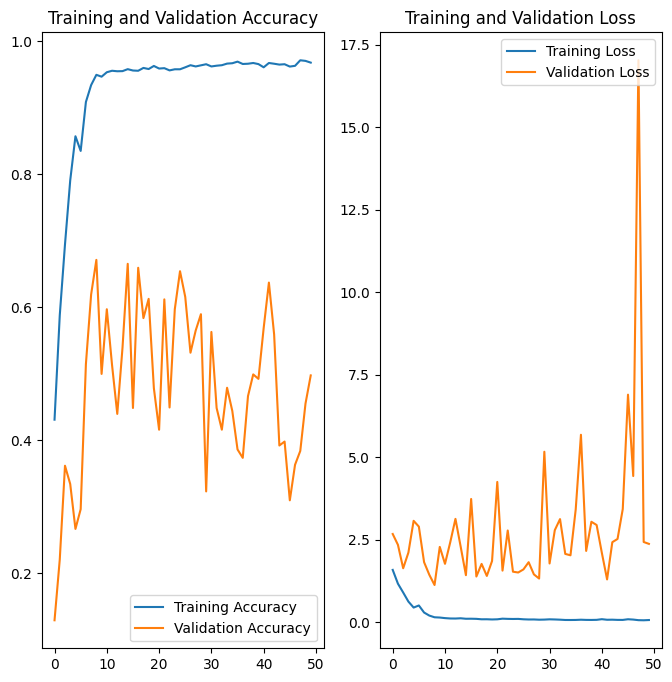

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Rebalencing the classes with the help of augmentor did help improve performance comparitively. However overfitting did not get eliminated. We require a deeper model that extracts more features from the images and try out other loss function.

